In [1]:
import os
from langgraph.prebuilt import create_react_agent
from langchain.agents import Tool
from langchain.tools import WikipediaQueryRun
from langchain.utilities import WikipediaAPIWrapper
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langgraph.graph import END
from langgraph.graph import StateGraph
from typing import Annotated, TypedDict, Sequence
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
# Create Retriever Tool
docs = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/").load()
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = splitter.split_documents(docs)
embedding = OpenAIEmbeddings()
vectorstore = FAISS.from_documents(chunks, embedding)
retriever = vectorstore.as_retriever()

In [3]:
retriever.invoke("what are autonomous agents")

[Document(id='c062da1a-dc19-4cb1-80fa-557e6bcf3299', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, 

In [5]:
def retriever_tool_func(query: str) -> str:
    print("📚 Using RAGRetriever tool")
    docs = retriever.invoke(query)
    return "\n".join([doc.page_content for doc in docs])

In [6]:
retriever_tool_func("what are autonomous agents")

📚 Using RAGRetriever tool


'Or\n@article{weng2023agent,\n  title   = "LLM-powered Autonomous Agents",\n  author  = "Weng, Lilian",\n  journal = "lilianweng.github.io",\n  year    = "2023",\n  month   = "Jun",\n  url     = "https://lilianweng.github.io/posts/2023-06-23-agent/"\n}\nReferences#\n[1] Wei et al. “Chain of thought prompting elicits reasoning in large language models.” NeurIPS 2022\n[2] Yao et al. “Tree of Thoughts: Dliberate Problem Solving with Large Language Models.” arXiv preprint arXiv:2305.10601 (2023).\nBoiko et al. (2023) also looked into LLM-empowered agents for scientific discovery, to handle autonomous design, planning, and performance of complex scientific experiments. This agent can use tools to browse the Internet, read documentation, execute code, call robotics experimentation APIs and leverage other LLMs.\nFor example, when requested to "develop a novel anticancer drug", the model came up with the following reasoning steps:\nCitation#\nCited as:\n\nWeng, Lilian. (Jun 2023). “LLM-powered

In [7]:
retriever_tool=Tool(
    name="RAGRetriever",
    description="Use this tool to fetch relevant knowledge base info",
    func=retriever_tool_func
    )
retriever_tool
print(retriever_tool.name)

RAGRetriever


In [8]:
# Wikipedia tool
wiki_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
wiki_tool

WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from 'c:\\Users\\Win 11\\Desktop\\Agentic AI Workspace\\env\\Lib\\site-packages\\wikipedia\\__init__.py'>, top_k_results=3, lang='en', load_all_available_meta=False, doc_content_chars_max=4000))

In [9]:
import os
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
llm=init_chat_model("openai:gpt-4o")

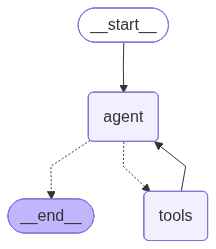

In [10]:
tools = [retriever_tool, wiki_tool]
## create the native Langgraph react agent
react_node=create_react_agent(llm,tools)
react_node

In [11]:
# LangGraph Agent State

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

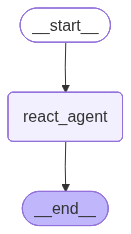

In [13]:
#  Build LangGraph Graph

builder = StateGraph(AgentState)
builder.add_node("react_agent", react_node)
builder.set_entry_point("react_agent")
builder.add_edge("react_agent", END)
graph = builder.compile()
graph

In [14]:
# Run the ReAct Agent

if __name__ == "__main__":
    user_query = "What is an agent loop and how does Wikipedia describe autonomous agents?"
    state = {"messages": [HumanMessage(content=user_query)]}
    result = graph.invoke(state)
    print(" Final Answer:", result["messages"][-1].content)

📚 Using RAGRetriever tool
 Final Answer: ### Agent Loop
The concept of an "agent loop" in AI involves a sequence where an agent continues to improve by using a learning mechanism. Each cycle of the loop includes actions that are predicted to perform better based on prior experiences, learning from the results, and updating the agent's internal model to improve future decisions. It emphasizes using reinforcement learning where the agent gets feedback for its actions, which help shape its next choices, aiming for continuous enhancement of performance over subsequent trials.

### Autonomous Agents
According to Wikipedia, an autonomous agent is defined as an artificial intelligence (AI) system capable of performing complex tasks independently. This definition is part of a broader understanding of intelligent agents, which are entities that perceive their environment and take actions independently to achieve specified goals. Intelligent agents can adapt and improve over time through mechani

In [15]:
import os
from typing import Annotated, Sequence, TypedDict
from langchain.agents import Tool
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import WebBaseLoader, ArxivLoader, TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.tools import WikipediaQueryRun
from langchain.utilities import WikipediaAPIWrapper
from langgraph.prebuilt import create_react_agent
from langgraph.graph import StateGraph, END
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph.message import add_messages
from langchain_community.document_loaders import TextLoader

In [18]:
### Generic function to create a retireval tool
def make_retriever_tool_from_text(file,name,desc):
    docs=TextLoader(file,encoding="utf-8").load()
    chunks = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50).split_documents(docs)
    vs = FAISS.from_documents(chunks, OpenAIEmbeddings())
    retriever = vs.as_retriever()

    def tool_func(query:str)->str:
        print(f"📚 Using tool: {name}")
        results = retriever.invoke(query)
        return "".join(doc.page_content for doc in results)
    
    return Tool(name=name,description=desc,func=tool_func)

# Wikipedia Tool
wiki_tool = Tool(
    name="Wikipedia",
    description="Use this tool to fetch general world knowledge from Wikipedia",
    func=WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
    )
    
# ArXiv Tool
def arxiv_search(query: str) -> str:
       print("🧪 Searching ArXiv...")
       results = ArxivLoader(query).load()
       return "".join(doc.page_content[:1000] for doc in results[:2]) or "No papers found."
arxiv_tool = Tool(
    name="ArxivSearch",
    description="Use this tool to fetch recent academic papers on technical topics.",
    func=arxiv_search
    )

In [20]:
internal_tool_1=make_retriever_tool_from_text(
    "sample_docs.txt",
    "InternalTechDocs",
    "Search internal tech documents for proprietary architecture and methods."
)

In [21]:
internal_tool_2 = make_retriever_tool_from_text(
    "research_notes.txt",
    "InternalResearchNotes",
    "Search internal research notes for experimental results and agent designs",
    )
internal_tool_2

Tool(name='InternalResearchNotes', description='Search internal research notes for experimental results and agent designs', func=<function make_retriever_tool_from_text.<locals>.tool_func at 0x0000024AFFCC4180>)

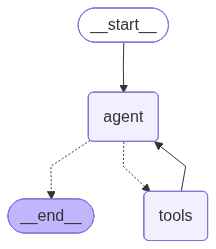

In [22]:
tools=[wiki_tool,arxiv_tool,internal_tool_1,internal_tool_2]
    
react_node=create_react_agent(llm,tools)
react_node

In [23]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

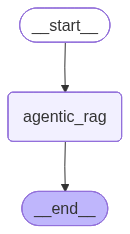

In [24]:
builder = StateGraph(AgentState)
builder.add_node("agentic_rag", react_node)
builder.set_entry_point("agentic_rag")
builder.add_edge("agentic_rag", END)
    
graph = builder.compile()
graph

In [27]:
query = "What do our internal research notes say about transformer variants, and what does ArXiv suggest recently?"
state = {"messages": [HumanMessage(content=query)]}
result = graph.invoke(state)
print("✅ Final Answer:", result["messages"][-1].content)

📚 Using tool: InternalResearchNotes
🧪 Searching ArXiv...
✅ Final Answer: Our internal research notes on transformer variants highlight several insights and experiments:

1. **EfficientFormer**:
   - Achieved 92.4% accuracy on TinyImageNet with low memory usage tailored for deployment on Raspberry Pi 4.
   - Performs well under quantized int8 mode without significant accuracy reduction.

2. **Longformer**:
   - Tested on customer support logs with attention to handling longer contexts.
   - Suggests chunk-based hybrid attention to mitigate latency issues.

3. **Reformer**:
   - Encountered challenges like bucket collisions and inconsistent loss spikes.
   - Solutions such as gradient clipping and memory-efficient attention modules were tried.

4. **TinyBERT**:
   - Used for prioritizing support tickets with an 87% F1 score, though faced confusion in specific classes.

Additional experiments include:

- **FlashAttention2** integration with LLaMA2, reducing context latency significantly.
